In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset, concatenate_datasets
import json
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
from model import Encoder, Encoder_pos_emb


ImportError: cannot import name 'load_dataset' from 'datasets' (unknown location)

In [2]:
# hyperparameters
hyper_params = {
    "block_size": 400, # what is the maximum context length for predictions?
    # "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "n_embd" : 64, #384
    "n_head" : 4,
    "n_layer" : 20,
    "dropout" : 0.2,
    "vocab_size" : 4
    }
# ------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

d_max = 9
d = 9 # must be an odd number
model = Encoder(hyper_params)
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

# p_err_train = 0.1
# p_err_val = 0.15
# dataset = load_dataset("json", data_files={
#         'train' : f"datasets/train_eos_original_mixed_{d_max}_p_{p_err_train:.2f}.json",
#         'val' : f"datasets/val_eos_original_mixed_{d_max}_p_{p_err_val:.2f}.json"
#         # 'train' : f"datasets/train_eos_original_d_{d}_p_{p_err_train:.2f}.json",
#         # 'val' : f"datasets/val_eos_original_d_{d}_p_{p_err_val:.2f}.json"
#     })

# pad_token = 3.0
# def collate_fn(examples):
#     target = [example['target'] for example in examples]
#     dist = [example['dist'] for example in examples]
#     input = []
#     attn_mask = []
#     for idx, example in enumerate(examples):
#         input.append(example['input'] + [pad_token]*(d_max**2 - dist[idx]**2))
#         attn_mask.append( [1.0]*(dist[idx]**2+1) + [0.0]*(d_max**2 - dist[idx]**2))
#     return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

# data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)#, shuffle = True)
# data_loader_val = DataLoader(dataset["val"], batch_size=batch_size, collate_fn=collate_fn)#, shuffle = True)
# # print(dataset["val"])

NameError: name 'Encoder' is not defined

In [19]:
# data hyperparams
batch_size = 600
p_err_train = 0.05
p_err_val = 0.15

d_list = [5,7,9]
d_max = max(d_list)
d = d_list[0]
mixed_dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_spiral_eos_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_spiral_eos_d_{d}_p_{p_err_val:.2f}.json",
    })
for d in d_list[1:]:
    dataset = load_dataset("json", data_files={
            'train' : f"datasets/train_spiral_eos_d_{d}_p_{p_err_train:.2f}.json",
            'val' : f"datasets/val_spiral_eos_d_{d}_p_{p_err_val:.2f}.json",
        })
    mixed_dataset['train'] = concatenate_datasets([mixed_dataset['train'],dataset['train']])
    mixed_dataset['val'] = concatenate_datasets([mixed_dataset['val'],dataset['val']])

print(mixed_dataset)

pad_token = 3.0
def collate_fn(examples):
    target = [example['target'] for example in examples]
    dist = [example['dist'] for example in examples]
    input = []
    attn_mask = []
    for idx, example in enumerate(examples):
        input.append(example['input'] + [pad_token]*((d_max+1)**2 - (dist[idx]+1)**2))
        attn_mask.append( [1.0]*((dist[idx]+1)**2+2) + [0.0]*((d_max+1)**2 - (dist[idx]+1)**2))
    return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

data_loader = DataLoader(mixed_dataset['train'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)
data_loader_val = DataLoader(mixed_dataset['val'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)


Generating train split: 200000 examples [00:00, 620900.97 examples/s]
Generating val split: 10000 examples [00:00, 570397.51 examples/s]
Generating train split: 200000 examples [00:00, 416250.04 examples/s]
Generating val split: 10000 examples [00:00, 380985.18 examples/s]
Generating train split: 200000 examples [00:00, 289166.92 examples/s]
Generating val split: 10000 examples [00:00, 268015.21 examples/s]

DatasetDict({
    train: Dataset({
        features: ['dist', 'errors', 'input', 'target'],
        num_rows: 600000
    })
    val: Dataset({
        features: ['dist', 'errors', 'input', 'target'],
        num_rows: 30000
    })
})


In [5]:
# pad_token = 3.0
# def collate_fn(examples):
#     target = [example['target'] for example in examples]
#     dist = [example['dist'] for example in examples]
#     input = []
#     attn_mask = []
#     for idx, example in enumerate(examples):
#         # print(example['input'])
#         # print([pad_token]*(d_max**2 - dist[idx]**2))
#         # print(example['input'] + [pad_token]*(d_max**2 - dist[idx]**2))
#         input.append(example['input'] + [pad_token]*(d_max**2 - dist[idx]**2))
#         attn_mask.append( [1.0]*(dist[idx]**2+1) + [float('-inf')]*(d_max**2 - dist[idx]**2))
#     # input = [example['input'] for example in examples]
#     return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

batch_size = 100
data_loader_val = DataLoader(mixed_dataset['val'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)

for batch in data_loader_val:
    print(batch['dist'])
    X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
    Y = torch.tensor(batch['target']).to(device)
    # probs, loss = model(X, attn_mask, Y)
    # last_token = torch.sum(attn_mask, dim=-1).to(torch.int32)
    # print(last_token)
    # print(X[torch.arange(batch_size),last_token-1])
    
    print(X.shape)
    print(attn_mask.shape)
    # print(Y.shape)
    # print(attn_mask.shape)
    break
# print(X.shape)
# print(probs)

[5, 9, 9, 9, 9, 5, 7, 5, 9, 9, 7, 7, 9, 5, 5, 7, 5, 9, 5, 5, 5, 7, 5, 5, 7, 9, 7, 9, 5, 7, 5, 7, 7, 7, 9, 7, 9, 5, 7, 5, 7, 5, 7, 9, 9, 5, 9, 9, 5, 7, 9, 9, 5, 5, 9, 7, 7, 5, 7, 9, 9, 7, 7, 9, 7, 7, 7, 7, 7, 5, 9, 9, 7, 7, 7, 9, 9, 9, 5, 9, 7, 5, 5, 7, 7, 5, 5, 7, 7, 9, 5, 5, 5, 5, 5, 9, 7, 9, 5, 5]
torch.Size([100, 102])
torch.Size([100, 102])


In [20]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, _ = model(X, attn_mask)
        pred = (err_probs > 0.5).to(Y)
        # print(err_probs.shape, Y.shape)
        acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [21]:
learning_rate = 5e-4
learning_rate_min = 0
eval_interval = 100
eval_iters =  10
num_epochs = 10

# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
cos_lr = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate_min)


loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    
    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # # if i_b>= eval_iters:
        # #     break
        # # # every once in a while evaluate the loss on train and val sets
        # # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1
        
    cos_lr.step()



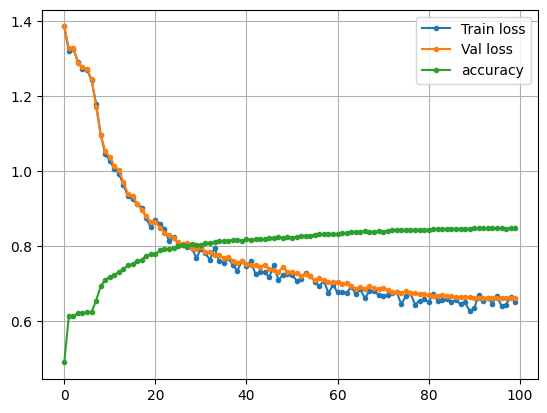

In [ ]:
plt.plot(loss_train,".-",label="Train loss")
plt.plot(loss_val,".-",label="Val loss")
plt.plot(acc_val,".-",label="accuracy")
# plt.xlim([0,250])
# plt.ylim([0,1])
plt.grid()
plt.legend()


In [ ]:
# PATH = f"model_params/lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"
# d_list = [5,7,9]
# PATH = f"model_params/sin_pos_emb_lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"
# PATH = f"model_params/sin_pos_emb_deep_lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"
PATH = f"model_params/sin_pos_emb_deep_p_{p_err_train:.2f}_lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"

print(PATH)
# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
    "epoch": epoch,
    "model_hyperparams": hyper_params,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict(),
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

model_params/sin_pos_emb_deep_p_0.15_lr_0.0005_d_5_9.pt


In [2]:
d_list = [5,7,9]
d_max = max(d_list)
learning_rate = 5e-4
FILE = f"model_params/sin_pos_emb_deep_lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"
# FILE = f"model_params/lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
# model = Encoder_pos_emb(checkpoint['model_hyperparams'])
model = Encoder(checkpoint['model_hyperparams'])
optimizer = torch.optim.AdamW(model.parameters(), lr=0)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

Encoder(
  (token_embdding_table): Embedding(4, 64)
  (position_embdding_table): Embedding(400, 64)
  (blocks): ModuleList(
    (0-19): 20 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2

In [12]:
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


batch_size = 1000
# p_err_list = torch.arange(0.01,0.31,0.01)
# p_err_list =  torch.arange(0.004,0.21,0.004) # 
p_err_list = torch.arange(0.01,0.16,0.01)
d_list = torch.arange(5,12,2)
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                # 'test' : f"../qec-data/datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
                'test' : f"datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                # acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
                acc[i_p,i_d] += torch.sum(torch.prod(pred == Y, dim=1)).item()/Y.shape[0]
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


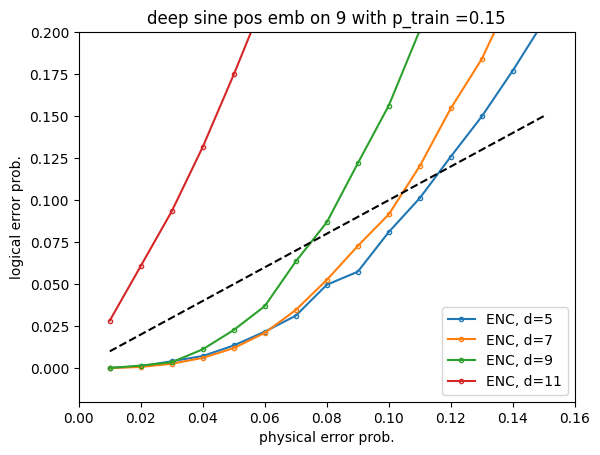

In [16]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    # p_err_list_mwpm,logical_err_mwpm = mwpm_file_reader(d)
    # plt.plot(p_err_list_mwpm,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],".-", color= f"C{i_d}",markerfacecolor="None",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.title(f"deep sine pos emb on {d_max} with p_train ={p_err_train:.2f}")# ft on {11}")
# plt.ylim([-0.02,0.47])
# plt.yscale("log")
plt.ylim([-0.02,0.2])
plt.xlim([0.,0.16])
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()


In [10]:
dataset = load_dataset("json", data_files={
        # 'test' : f"../qec-data/datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
        'test' : f"datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
    })
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['dist', 'errors', 'input', 'target'],
        num_rows: 10000
    })
})


In [41]:
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


batch_size = 1000
p_err_list = torch.arange(0.01,0.12,0.01)
threshold_list = torch.arange(0.1,0.91,0.1)
# p_err_list =  torch.arange(0.004,0.21,0.004) # 
d = 9
acc = torch.zeros((p_err_list.shape[0],len(threshold_list)))

model.eval()
for i_p, p_err in enumerate(p_err_list):
    dataset = load_dataset("json", data_files={
            # 'test' : f"../qec-data/datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
            'test' : f"datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
        })
    data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)
    with torch.no_grad():
        for i_t, threshold in enumerate(threshold_list):
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > threshold).to(Y)
                # acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
                acc[i_p,i_t] += torch.sum(torch.prod(pred == Y, dim=1)).item()/Y.shape[0]
            # print(i_b)
            acc[i_p,i_t] /= (i_b+1)

# model.train()
# del model


0.10000000149011612
0.20000000298023224
0.6000000238418579
0.6000000238418579
0.5
0.699999988079071
0.5
0.5
0.6000000238418579
0.6000000238418579
0.5


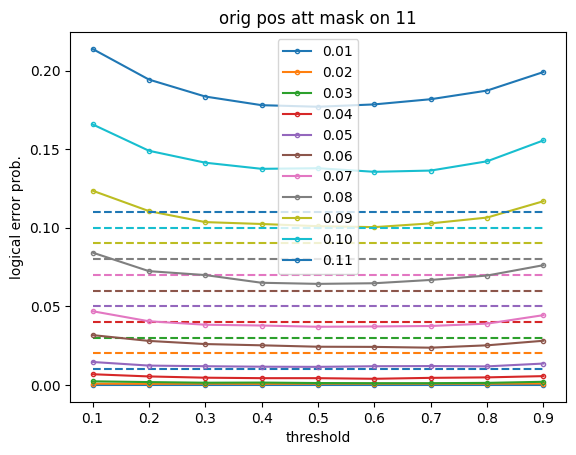

In [40]:

for i_p, p_err in enumerate(p_err_list):
    # plt.plot(threshold_list,(1-acc[i_p,:])/(1-acc[i_p,:]).min(),".-", color= f"C{i_p}",markerfacecolor="None",label=f"{p_err:.2f}")
    plt.plot(threshold_list,(1-acc[i_p,:]),".-", color= f"C{i_p}",markerfacecolor="None",label=f"{p_err:.2f}")
    print(threshold_list[(1-acc[i_p,:]).argmin()].item())
    plt.plot(threshold_list,threshold_list*0+p_err,"--",color= f"C{i_p}")
plt.title(f"orig pos att mask on {d_max}")
# plt.ylim([.9,2])
# plt.ylim([-0.02,0.15])
# plt.yscale("log")
plt.xlabel("threshold")
plt.ylabel("logical error prob.")
plt.legend()
